# Code setup

In [12]:
try:
    %load_ext lab_black
except ModuleNotFoundError:
    print("Couldn't load Black autoformatter.")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [13]:
# To suppress warning output
import warnings

# warnings.filterwarnings("ignore")
# warnings.simplefilter("ignore")

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys
import math

# Set random seed across notebook for repeatable results
np.random.seed(1922)  # for Papa

In [14]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

matplotlib.rcParams["font.family"] = ["sans-serif"]
matplotlib.rcParams["font.sans-serif"] = [
    "Source Sans 3",
    "Helvetica",
    "Arial",
    "sans-serif",
]
plt.rcParams["axes.titlesize"] = "x-large"  # 16
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "x-large"

In [15]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)):
    print("Figure directory did not exist, creating now.")
    os.mkdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)
else:
    print("Figure directory exists.")

Figure directory exists.


In [16]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt

importlib.reload(blt)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
Figure directory exists.


<module 'functions' from '/app/src/functions.py'>

# Data

In [17]:
# Target (ENM) data

# Read in ENM feature data
X_enm = pd.read_csv(
    "./data/ENM-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)
# Read in ENM labels (maximum_weight_fraction)
y_enm = pd.read_csv("./data/ENM-clean.csv", sep=",", header="infer", usecols=[4])
print("X_enm shape:", X_enm.shape)
print("y_enm shape:", y_enm.shape)

X_enm shape: (112, 53)
y_enm shape: (112, 1)


In [18]:
# Source (bulk organics) data

# Read in source feature data
X_source = pd.read_csv(
    "./data/organics-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)
# Read in source labels (maximum_weight_fraction)
y_source = pd.read_csv(
    "./data/organics-preprocessed-WF.csv", sep="\t", header="infer", index_col=0
)
y_source.index = X_source.index
print("X_source shape:", X_source.shape)
print("y_source shape:", y_source.shape)

X_source shape: (16439, 53)
y_source shape: (16439, 1)


In [19]:
# View ENM feature df
X_enm.head(4)

,cprp_MW,cprp_MP,cprp_BP,cprp_density,func_absorbent,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,func_biocide,func_brightener,...,pgrp_makeuprelated,pgrp_nutritionalsupplements,pgrp_paintstainrelated,pgrp_portableairprocessing,pgrp_sunscreen,pgrp_surfacesealers,pgrp_toys,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
0,79.867,1843.00,2972.0,4.230,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,63.546,1083.00,2567.0,8.960,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
2,65.370,419.53,907.0,7.140,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,107.868,961.78,2162.0,10.345,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
# Read in previous model evaluation results tables
results_prelim = pd.read_csv("./data/results-prelim.csv", sep="\t", na_values="nan")
results_final = pd.read_csv("./data/results-final.csv", sep="\t", na_values="nan")
results_svc = pd.read_csv("./data/results-SVC.csv", sep="\t", na_values="nan")
results_rfc = pd.read_csv("./data/results-RFC.csv", sep="\t")
results_permute = np.loadtxt("./data/results-permutation-SVC.txt")
results_svc_diam = pd.read_csv("./data/results-SVC-diam.csv", sep="\t", na_values="nan")

### Apply alternate variables

We will be using "diameter" and molar volume as alternative features for MW (which must also replace density, as this is used in the equation). For comparison with the measured diameters of ENM, the effective "diameter" of an organic compound (assumed to be spherical), $d_{org}$, is calculated as such:

$$m = \frac{M}{N_A} n $$ <br>
$$m = \frac{\pi}{6} \rho d_{org}^3 n $$ <br>
$$d_{org} = \sqrt[3]{\frac{6M}{\pi \rho N_A}} $$ <br>

where $m$ is the mass of a pure material in grams; $M$ is its molecular weight in grams per mole; $N_A = 6.022\mathrm{E}{23}$ molecules per mole, or Avagadros number; $n$ is the number of molecules; and $\rho$ is density in grams per cubic centimeter.

Molar volume, $V_N$, is easily calculated from the above.

$$ V_{N_{org}} = d_{org}^3 N_A = \frac{6M}{\pi\rho} $$ <br>
$$V_{N_{ENM}} = d_{ENM}^3 N_{ENM} = \frac{6M}{\pi\rho} $$ <br>

The constants may be ignored, simplifying to:

$$V_{N_{org}} = \frac{M}{\rho} $$ <br>
$$V_{N_{ENM}} = \frac{M}{\rho} $$ <br>

In [10]:
from scipy import constants


def diameterorg(MW, density):
    diam = ((6 * MW) / (math.pi * density * constants.N_A)) ** (1.0 / 3)
    return diam


def molvolume(MW, density):
    MV = MW / density
    return MV

In [11]:
# Apply new functions to datasets
X_source["cprp_diameter"] = diameterorg(X_source["cprp_MW"], X_source["cprp_density"])
X_source["cprp_isdiamimputed"] = 0
X_enm["cprp_MV"] = molvolume(X_enm["cprp_MW"], X_enm["cprp_density"])
X_source["cprp_MV"] = molvolume(X_source["cprp_MW"], X_source["cprp_density"])

In [92]:
# Create alternative datasets
cols_new = X_enm.columns.tolist()
cols_diam = (
    [cols_new[-5]]
    + [cols_new[-4]]  # 'cprp_diameter'
    + [cols_new[1]]  # 'cprp_isdiamimputed'
    + cols_new[3:-5]  # 'cprp_MP'
)  # all other features
cols_MV = (
    [cols_new[-1]] + [cols_new[1]] + cols_new[3:-5]  # 'cprp_MV'  # 'cprp_MP'
)  # all other features

X_enm_diam = pd.DataFrame(X_enm[cols_diam])
X_enm_MV = pd.DataFrame(X_enm[cols_MV])
X_enm = pd.DataFrame(X_enm[cols_orig])

X_source_diam = pd.DataFrame(X_source[cols_diam])
X_source_MV = pd.DataFrame(X_source[cols_MV])
X_source = pd.DataFrame(X_source[cols_orig])

y_enm_diam = pd.DataFrame(y_enm)
idx = X_enm_diam.index.values.tolist()
y_enm_diam = y_enm_diam.iloc[idx, :]

In [93]:
# TODO: check if this hasn't already been done
# Convert ENM diameter units from nanometers to centimeters
X_enm_diam["cprp_diameter"] = X_enm_diam["cprp_diameter"] / 1000000

KeyError: 'cprp_diameter'

## Apply WF bins

Labels (continuous WF data) will be binned into low (0.0-0.0001), medium (0.0001-0.01) and high (0.01-1.0) categories.

In [21]:
# Apply bins to ENM and organics data
bin_enm = np.asarray(y_enm.apply(blt.bins, axis=1))
# bin_enm_diam = np.asarray(y_enm_diam.apply(blt.bins, axis=1))
bin_source = np.asarray(y_source.apply(blt.bins, axis=1))

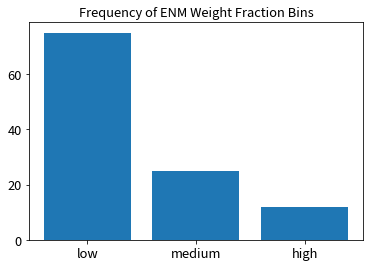

Label bin:  [0 1 2]
Count    :  [75 25 12]
Frequency:  [0.67, 0.22, 0.11]


In [22]:
# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_enm, data_composition="ENM")

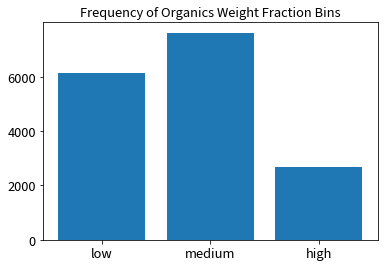

Label bin:  [0 1 2]
Count    :  [6127 7617 2695]
Frequency:  [0.37, 0.46, 0.16]


In [23]:
# View bar plot of Organics WF bins
blt.bar_graph_bins(bin_source, data_composition="Organics")

## Visualize chemical space

/app/env/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


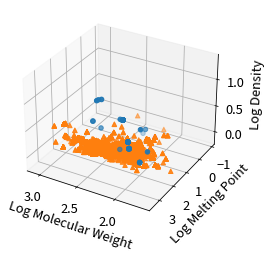

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for m, df in [("o", X_enm), ("^", X_source)]:
    mw = np.log10(df.cprp_MW)
    mp = np.log10(df.cprp_MP)
    ds = np.log10(df.cprp_density)
    ax.scatter(mw, mp, ds, marker=m)

ax.set_xlabel("Log Molecular Weight")
ax.set_ylabel("Log Melting Point")
ax.set_zlabel("Log Density")
ax.view_init(azim=120)  # set rotation angle of plot
fig.show()

Text(0.5, 0, 'Log Density')

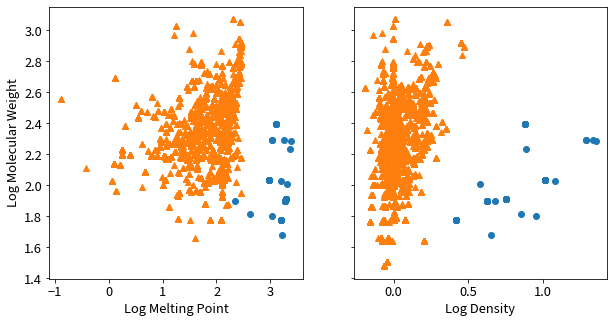

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for m, df in [("o", X_enm), ("^", X_source)]:
    mw = np.log10(df.cprp_MW)
    mp = np.log10(df.cprp_MP)
    ax1.scatter(mp, mw, marker=m)
ax1.set_ylabel("Log Molecular Weight")
ax1.set_xlabel("Log Melting Point")

for m, df in [("o", X_enm), ("^", X_source)]:
    ds = np.log10(df.cprp_density)
    mw = np.log10(df.cprp_MW)
    ax2.scatter(ds, mw, marker=m)
ax2.set_xlabel("Log Density")

## Pre-check PCA

In [46]:
def pca_precheck(X, n_components, thres_btm=0.75, thres_top=0.85):
    """List PCA components for hyperparameterization

    Find a reasonable range of n_components to try during hyperparameterization.
    Returns a list of integers.

    Arguments
    ---------
    X : DataFrame
        Feature data for dimension reduction
    n_components : int
        A generous number of PCA components to test
    thres_btm : float (default=0.75)
        The minimum cumulative explained variance threshold to aim for; a fraction
    thres_top : float (default=0.85)
        The maximum cumulative explained variance threshold to aim for
    """

    from sklearn.preprocessing import MinMaxScaler
    from sklearn import decomposition

    # Scale the data first (e.g., chemical properties) from 0 to 1
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(X_scaled)
    cum_evr = np.cumsum(pca.explained_variance_ratio_)

    # Figure out number of components to achieve desired cumulative explained variance
    component_list = np.where((cum_evr > thres_btm) & (cum_evr < thres_top))[0]
    # component_list = component_list + (component_list[-1]+1)

    # Plot just to double check / visualize
    fig = plt.figure()
    plt.plot(cum_evr, ".-", label="pca")
    plt.plot([0, n_components], [thres_btm, thres_btm], "k", label=thres_btm)
    plt.plot([0, n_components], [thres_top, thres_top], "r", label=thres_top)
    plt.xlabel("Coefficient Number")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.grid()
    plt.legend()
    plt.show()

    return component_list.tolist()

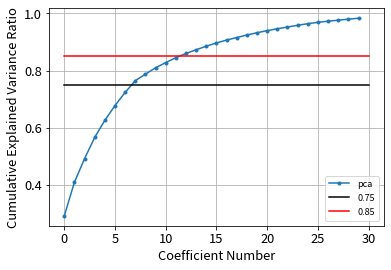

[7, 8, 9, 10, 11]


In [47]:
component_list = pca_precheck(X=X_enm, n_components=30, thres_btm=0.75, thres_top=0.85)
print(component_list)

# Model optimization

Modeling functions are all called from an external python file, $functions.py$, loaded at the beginning of this script. These will optimize, execute and evaluate different classifiers on several different training datasets using stratified cross validation (CV).

A machine learning pipeline is used to (optionally) augment training data with source (organic chemical products) data, normalize features on a 0 to 1 scale, reduce feature dimensionality using PCA, then run a classifer (SVC-RBF or RFC) using stratified cross validation. Model parameters are optimized using a parameter grid search.

This table summarizes what the CV pipeline does for each CV fold in terms of X/y and training/testing data. We have altered the "fit" step of sk-learn's Pipeline, which "only transform[s] the observed data (X)" (https://scikit-learn.org/stable/modules/compose.html), so that the y training data will also be transformed in the data augmentation step.

|     Pipeline Step                |     X_train                    |     y_train              |     X_test (ENM only)    |     y_test (ENM only)    |
|----------------------------------|--------------------------------|--------------------------|--------------------------|--------------------------|
|     (1) Data augmentation        |     fit, transform +mask    |     fit, transform    |                          |                          |
|     (2) Min-max scaling          |     fit, transform             |                          |     transform            |                          |
|     (3) Feature reduction    |     fit, transform       |                          |     transform            |                          |
|     (4) Classification           |     fit, predict               |     fit, predict         |     predict              |     predict              |

Unsupervised and supervised data augmentation rely on cosine similarity to determine which samples from the source dataset are most similar to each sample in the target dataset. 

$\text{cosine similarity} = \frac{A \cdotp B}{\parallel A \parallel \parallel B \parallel} $

We are assuming that the chemical properties of our source data are very different from our target data, so when looking for similar observations to pair, we want to exclude chemical properties from the similarity calculation by applying a *feature mask*. The mask will set chemical property features to zero so that they are effectively ignored by cosine similarity (only during data augmentation). Because chemical properties are the only features that aren't on a scale from 0 to 1, this also means we can perform data augmentation prior to min-max scaling in the cross validation pipeline.

Resource for writing custom sklearn transformers:
https://towardsdatascience.com/writing-custom-scikit-learn-transformers-e07a3cf7b559

In [18]:
import random as pyrandom
from numpy import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler

# Define feature mask for data augmentation
feat_names = X_enm.columns
col_mask = ["cprp" not in name for name in feat_names]


# Functions for different data augmentation methods


def random_augment(k, X_source, y_source, random_state, X, y):
    """Randomly samples source data to pair with target data."""

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Number of samples to select
    n_samples = k * len(X)
    # Obtain indices for randomly sampling source data
    idx_match = np.random.choice(len(X_source), n_samples)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    assert (
        X_aug.shape[0] == y_aug.shape[0]
    ), f"X_aug.shape={X_aug.shape}, y_aug.shape={y_aug.shape}"

    return X_aug, y_aug


def unsupervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Unsupervised data augmentation

    Match "k" most similar source data samples to target data samples
    based on the smallest cosine distance between target and source data
    samples (i.e., in an supervised fashion).
    """

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Cosine distance matrix using feature mask
    cosdist_samples = cosine_distances(X_source * col_mask, X * col_mask)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in cosdist_samples.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))

    return X_aug, y_aug


def supervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Supervised data augmentation

    Match "k" most similar source data samples to target data samples
    based on the smallest average of cosine distance between samples
    and distance between WF labels (i.e., in an supervised fashion).
    """

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Cosine distance matrix using feature mask
    cosdist_samples = cosine_distances(X_source * col_mask, X * col_mask)
    # For supervised matching augmentation, also consider WF labels
    # Turn 1D label arrays into 2D arrays
    y_2d = np.tile(y, (len(y_source), 1))
    y_source_2d = np.tile(y_source, (len(y), 1)).transpose()
    # Get normalized distance between ENM and organics labels
    scaler = MinMaxScaler()
    dist_y = scaler.fit_transform(np.abs(y_2d - y_source_2d).astype(float))
    # Average distances of features and labels
    dist_matrix = (0.95 * cosdist_samples) + (0.05 * dist_y)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in dist_matrix.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))

    return X_aug, y_aug

In [19]:
# Define models and parameters
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt

random_state = 1922
augmentation_kwargs = {
    "augmentation_random_state": random_state,
    "augmentation_X_source": X_source,
    "augmentation_y_source": bin_source,
}

models = {
    "RandomForestClassifier": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                RandomForestClassifier(
                    class_weight="balanced", random_state=random_state
                ),
            ),
        ],
        **augmentation_kwargs
    ),
    "SVC": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",  # balance by class size
                    random_state=random_state,
                ),
            ),
        ],
        **augmentation_kwargs
    ),
}
params = {
    "RandomForestClassifier": {
        "augmentation_type": [random_augment, unsupervised_augment, supervised_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],
        "dimreducer__n_components": [8, 9, 10, 11, 12],
        "estimator__max_depth": np.arange(2, 15, 2),
    },
    "SVC": {
        "augmentation_type": [random_augment, unsupervised_augment, supervised_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],
        "dimreducer__n_components": [8, 9, 10, 11, 12],
        "estimator__C": np.logspace(-1, 7, 9),
        "estimator__gamma": np.logspace(-7, 1, 9),
    },
}

In [136]:
results_prelim = blt.apply_model_opt(
    models, params, X_target=X_enm, y_target=bin_enm, cust_folds=5, n_jobs=1
)

Running GridSearchCV for RandomForestClassifier.
Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1680 out of 1680 | elapsed:  5.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Running GridSearchCV for SVC.
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   17.5s finished


RandomForestClassifier
SVC


In [30]:
results_prelim

,estimator,min_score,mean_score,max_score,std_score,augmentation_k,augmentation_type,n_components,max_depth,C,gamma
0,SVC,0.511111,0.706667,0.866667,0.126803,20,<function random_augment at 0x11f2508c8>,10,NaN,1000000.0,0.001000
1,SVC,0.555556,0.704444,0.800000,0.089332,5,<function random_augment at 0x11fd1b048>,12,NaN,10000.0,0.010000
2,RandomForestClassifier,0.511111,0.684444,0.933333,0.141526,3,<function random_augment at 0x11f2508c8>,8,2.0,NaN,NaN
3,SVC,0.600000,0.673333,0.777778,0.057778,2,<function random_augment at 0x11f2508c8>,8,NaN,10000000.0,0.000100
4,SVC,0.511111,0.671111,0.866667,0.125236,5,<function random_augment at 0x11f2508c8>,10,NaN,1000000.0,0.000100
...,...,...,...,...,...,...,...,...,...,...,...
10555,SVC,0.044444,0.200000,0.355556,0.130337,20,<function random_augment at 0x11fd1b048>,12,NaN,100000.0,0.000001
10556,SVC,0.066667,0.191111,0.400000,0.119753,20,<function random_augment at 0x11f2508c8>,10,NaN,100000.0,0.000010
10557,SVC,0.066667,0.186667,0.333333,0.104798,20,<function random_augment at 0x11fd1b048>,11,NaN,100000.0,0.000010
10558,SVC,0.066667,0.177778,0.355556,0.120902,20,<function random_augment at 0x11fd1b048>,12,NaN,100000.0,0.000010


In [159]:
# Export preliminary results table to .csv
results_prelim.to_csv(
    "./data/results-prelim.csv", sep="\t", header="infer", na_rep="NaN", index=False
)

# Model evaluation

For model evaluation, optimized models are tested over 30 trials using stratified cross validation on the original ENM product data. Original data was used instead of a holdout set due to the paucity of data available. 

A normalized confusion matrix summarizes balanced accuracy results according to each WF bin (class). The average normalized balanced accuracy across all bins is then calculated from the confusion matrix.

## SVC-RBF

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


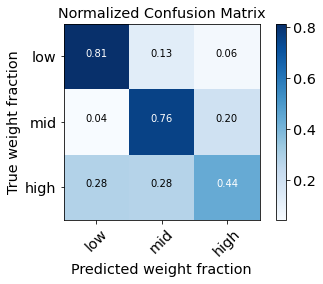

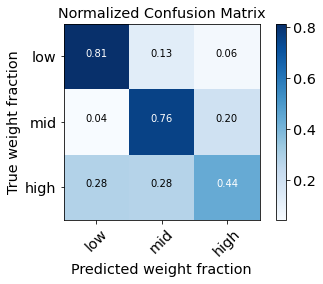

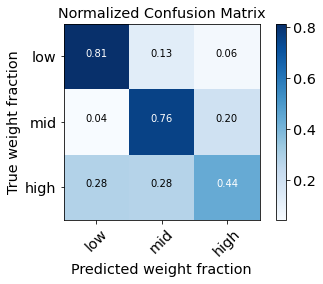

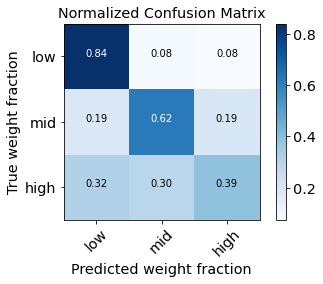

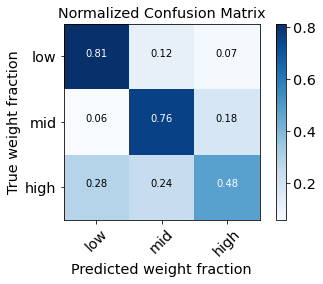

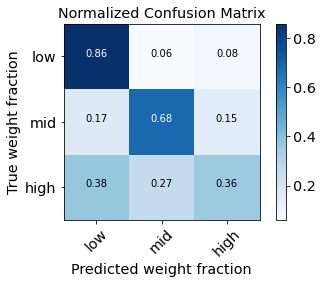

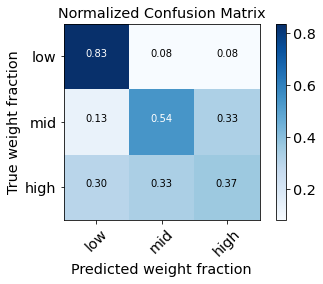

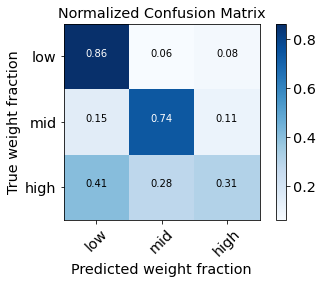

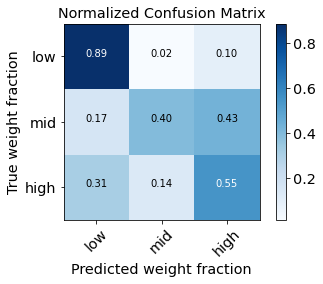

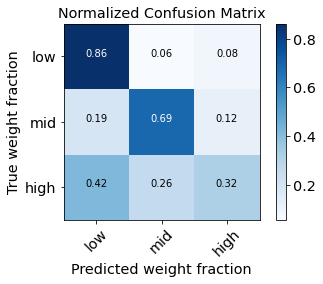

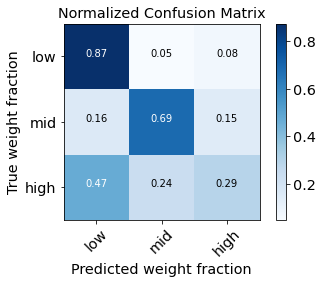

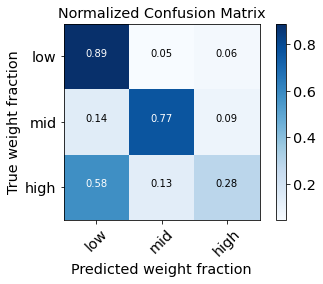

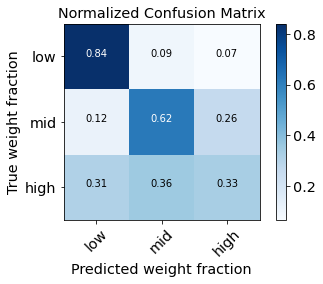

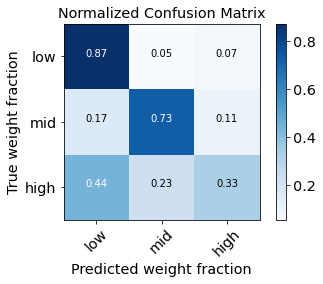

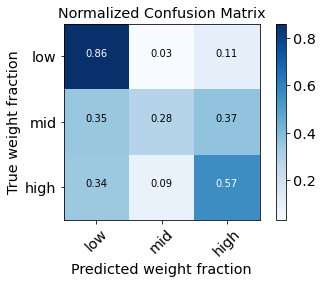

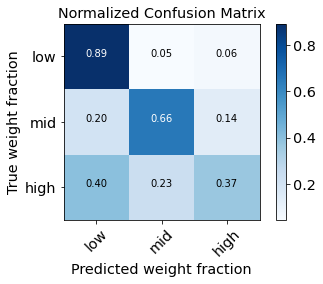

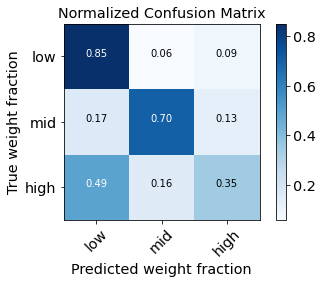

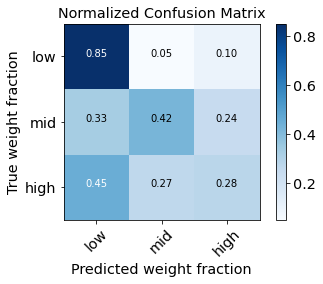

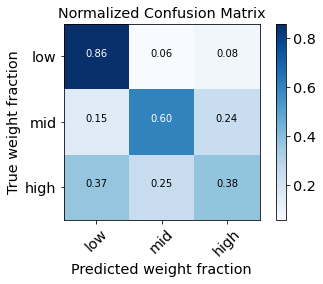

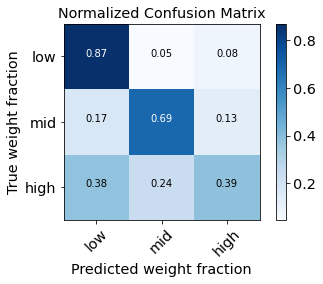

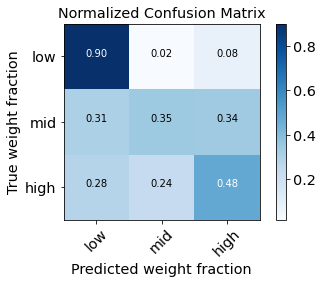

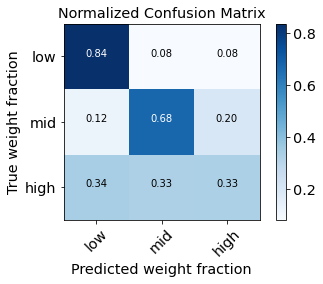

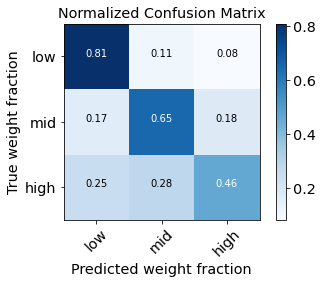

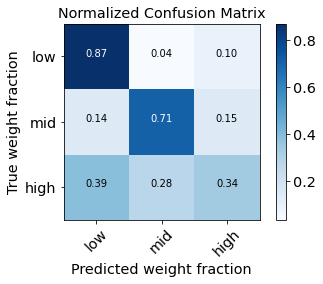

In [31]:
# SVC
results_svc = blt.run_hyperparams(
    results_prelim[results_prelim["estimator"] == "SVC"].astype(object),
    cust_folds=5,
    random_state=np.arange(100),
    show_feat_impt=False,
)

## RFC

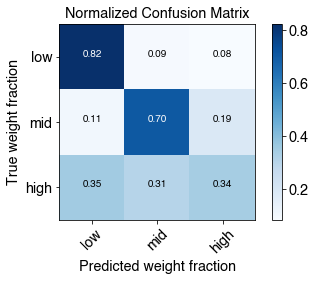

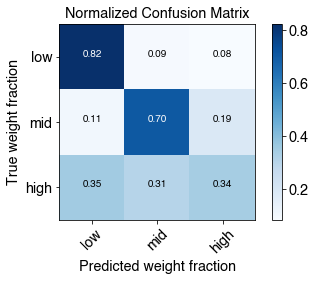

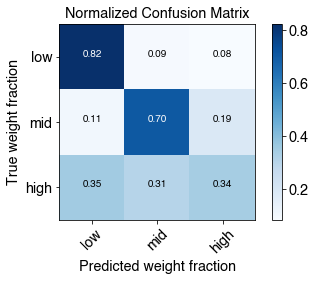

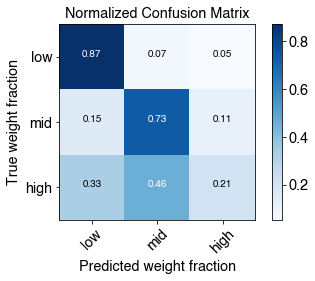

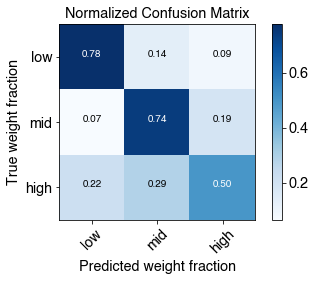

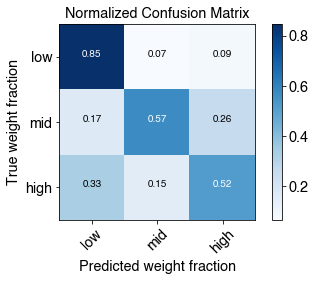

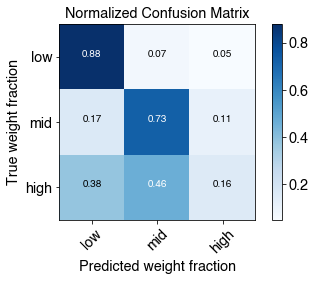

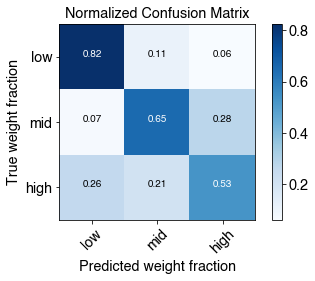

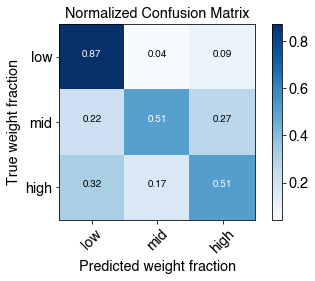

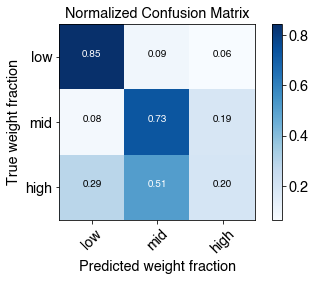

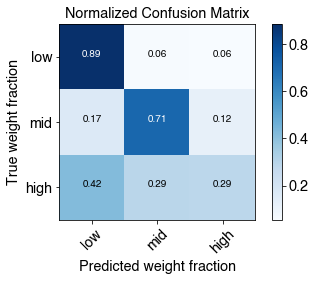

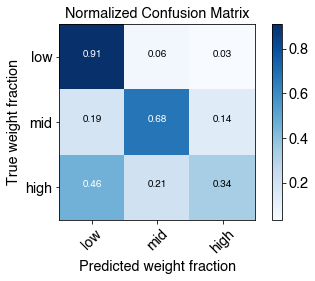

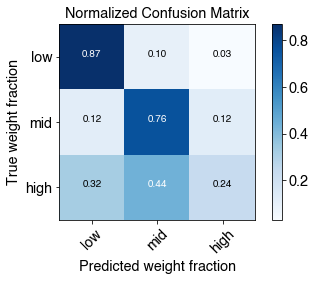

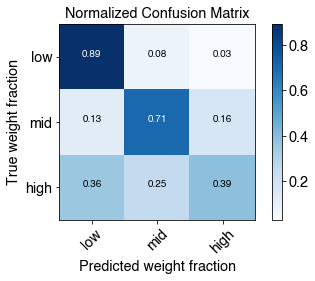

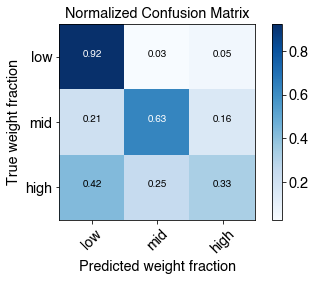

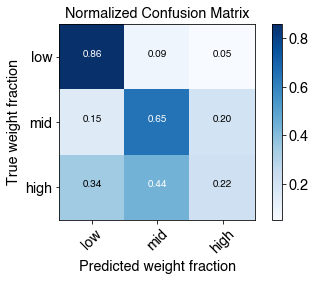

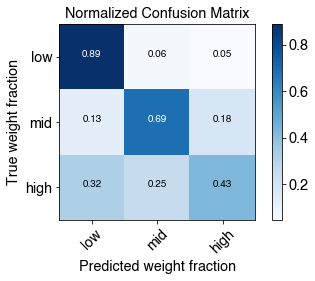

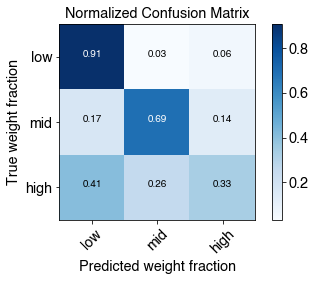

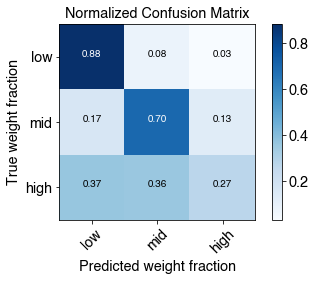

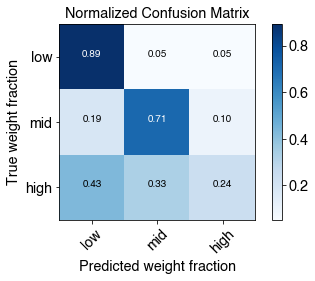

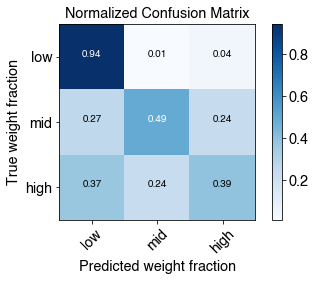

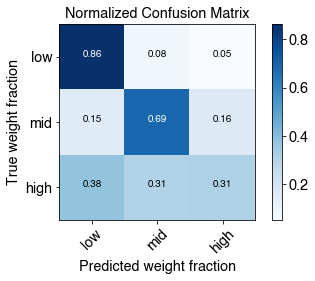

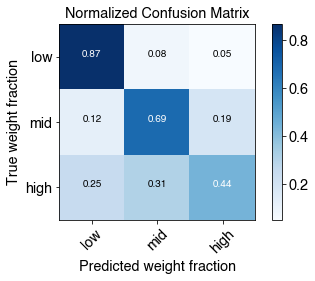

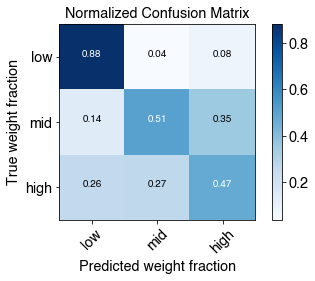

In [160]:
# RFC
results_rfc = blt.run_hyperparams(
    results_prelim[results_prelim["estimator"] == "RandomForestClassifier"],
    cust_folds=5,
    random_state=np.arange(100),
    show_feat_impt=False,
)

# Performance results

Note that data augmentation was not performed on data frames only containing ENM data (non-permuted and permuted).

In [165]:
# Export results tables to .csv
results_svc.to_csv(
    "./data/results-SVC.csv", sep="\t", header="infer", na_rep="NaN", index=False
)
results_rfc.to_csv(
    "./data/results-RFC.csv", sep="\t", header="infer", na_rep="NaN", index=False
)

In [ ]:
# Export alternative results table to .csv
#results_svc_diam.to_csv("./data/results-SVC-diam.csv", sep='\t', header='infer', na_rep='NaN', index=False)

In [172]:
def display_table(df, df2=None):
    """Redisplay results as table for publication."""

    if isinstance(df2, pd.DataFrame):
        df = pd.concat([df, df2])

    # Tidy up labels, decimal places
    df["estimator"] = df["estimator"].str.replace("RandomForestClassifier", "RFC")
    df["augmentation_type"] = df["augmentation_type"].str.title()
    df["augmentation_type"] = df["augmentation_type"].str.replace("_", "")
    df["augmentation_type"] = df["augmentation_type"].str.replace(
        "augment", "Augment"
    )  # TODO: why title() didn't work?
    df["std_err_avg"] = [np.average(i) for i in df["std_err"]]
    pd.set_option("display.precision", 3)

    # Pivot table
    table = df.pivot(
        index=["augmentation_k", "augmentation_type"],
        columns="estimator",
        values="score_avg",
    )
    errors = df.pivot(
        index=["augmentation_k", "augmentation_type"],
        columns="estimator",
        values="std_err_avg",
    )

    return table, errors

In [173]:
table_svc, errors_svc = display_table(results_svc)
# table_svc.to_latex("./data/texresults_svc")
# table_svc

In [177]:
table_all, table_errors = display_table(results_rfc, results_svc)
table_all

estimator                             RFC    SVC
augmentation_k augmentation_type                
0              RandomAugment        0.623   0.67
               SupervisedAugment    0.623   0.67
               UnsupervisedAugment  0.623   0.67
1              RandomAugment        0.605  0.613
               SupervisedAugment    0.672  0.684
               UnsupervisedAugment  0.645  0.633
2              RandomAugment        0.588  0.586
               SupervisedAugment    0.669  0.637
               UnsupervisedAugment  0.631  0.612
3              RandomAugment        0.591  0.621
               SupervisedAugment    0.627  0.619
               UnsupervisedAugment  0.641  0.648
4              RandomAugment        0.622  0.605
               SupervisedAugment    0.664  0.643
               UnsupervisedAugment  0.627  0.568
5              RandomAugment        0.575  0.644
               SupervisedAugment    0.667  0.635
               UnsupervisedAugment  0.644  0.519
10             RandomAugment        0.619  0.611
               SupervisedAugment    0.614  0.646
               UnsupervisedAugment  0.609  0.577
20             RandomAugment        0.623  0.621
               SupervisedAugment    0.663   0.64
               UnsupervisedAugment  0.621  0.641

To get error bars working: https://stackoverflow.com/questions/52035184/pandas-plot-line-graph-with-both-error-bars-and-markers

In [175]:
def line_plot(df, errors=None, save_fig_name=None):

    if isinstance(errors, pd.DataFrame):
        errors = errors.unstack(level=[1])
    pltstyle = [":", ":", ":", "-", "-", "-"]
    pltcolor = ["tab:olive", "royalblue", "navy"]
    myplot = df.unstack(level=[1]).plot(
        kind="line", subplots=False, style=pltstyle, color=pltcolor, yerr=errors
    )
    plt.title("Performance of Classification Models", pad=10)
    plt.xlabel("Augmentation $k$")
    plt.ylabel("Average Balanced Accuracy")
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.gca().legend(loc="lower center", bbox_to_anchor=(0.5, -0.45), ncol=2)
    if save_fig_name:
        fig = myplot.get_figure()
        blt.savepdf(fig, save_fig_name)

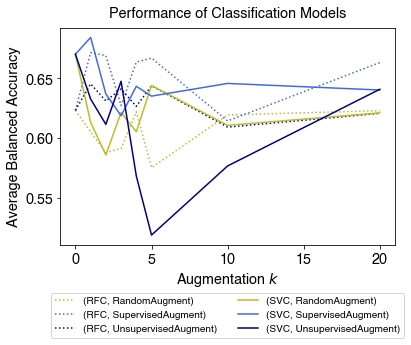

In [176]:
line_plot(df=table_all, errors=None, save_fig_name="bal-accu-plot")

## Permutation test

The following tests are performed with randomly permuted labels (ENM data only).

In [262]:
def permutation_test(num_trials, classifier):

    # Set random seeds for each trial
    seed_set = np.random.choice(np.arange(0, 100), size=num_trials, replace=False)
    print(seed_set, type(seed_set))
    # Select model parameters (later filtered for optimized parameters)
    model_params = results_prelim.loc[
        (results_prelim["estimator"].str.contains(classifier))
        & (results_prelim["augmentation_k"] == 0)
        & (results_prelim["augmentation_type"].str.contains("random"))
    ]

    # Placeholder
    results_permute = np.empty(num_trials)  # np.empty(seed_set.size)
    # Iterate across model trials
    for idx, s in enumerate(seed_set):
        bin_enm_permute = np.random.RandomState().permutation(bin_enm)
        with blt.HiddenPrints():
            results_permute[idx] = blt.run_hyperparams(
                df_params=model_params,
                random_state=[1922],
                X=X_enm,
                y=bin_enm_permute,
                cust_folds=5,
                show_feat_impt=False,
            )

    mu_permute = results_permute.mean()
    sigma_permute = results_permute.std()
    print("Classifier: ", classifier)
    print("Avg accuracy:    ", mu_permute)
    print("Median accuracy: ", np.median(results_permute))
    print("StdDev accuracy: ", sigma_permute)
    print("Numer of trials: ", num_trials)
    print("Results: ", results_permute)
    return mu_permute, sigma_permute, results_permute

In [276]:
model_params = results_prelim.loc[
    (results_prelim["estimator"].str.contains("SVC"))
    & (results_prelim["augmentation_k"] == 0)
    & (results_prelim["augmentation_type"].str.contains("random"))
]

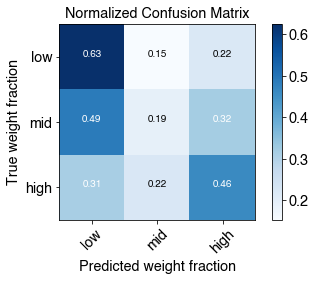

In [277]:
model_params = results_prelim.loc[
    (results_prelim["estimator"].str.contains("RandomForestClassifier"))
    & (results_prelim["augmentation_k"] == 0)
    & (results_prelim["augmentation_type"].str.contains("random"))
]
results_permute = blt.run_hyperparams(
    df_params=model_params,
    X=X_enm,
    y=np.random.RandomState().permutation(bin_enm),
    cust_folds=5,
    show_feat_impt=False,
)

In [278]:
results_permute

,estimator,augmentation_type,augmentation_k,score_avg,score_list,std_err
0,RandomForestClassifier,random_augment,0,0.427,"[0.42444444444444446, 0.4422222222222222, 0.38...","[0.02419060117453026, 0.07013215039137555, 0.0..."


In [ ]:
# Export permutation results to text file
np.savetxt('./data/results-permutation-SVC.txt', results_permute, 
           delimiter='\t', fmt='%.2f')

In [ ]:
# Check normality of test results for permutations, baseline and best models
from scipy.stats import normaltest
for i in [results_permute, base_distrib, match_distrib]:
    print(normaltest(i))

The p-value of our first normality test is above alpha=0.05, so it is fairly safe to assume that the permutation test results can be adequately represented by a normal distribution. The distribution for our best augmentation model does not pass, however. So a non-parametric test should be used for that data.

In [ ]:
# Get average balanced accuracy for models of interest
mu = results_svc.loc[results_svc['ENM-Organics-Ratio']=='1:0', 
                     'Avg-Random-Augment'].values
mu_permute = results_svc.loc[results_svc['ENM-Organics-Ratio']=='1:0*', 
                             'Avg-Random-Augment'].values
mu_match = results_svc.iloc[results_svc['Avg-Unsupervised-Match'].idxmax(), 3]

In [ ]:
# Plot permutation test results
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Plot histograms
plt.rcParams['font.size'] = 10
plt.hist(results_permute, bins=25, facecolor='orange', alpha=0.3)
plt.hist(base_distrib, facecolor='red', alpha=0.3)
plt.hist(match_distrib, facecolor='navy', alpha=0.3)

# Stats for distributions
std_permute = norm.fit(results_permute)[1]
std_base = norm.fit(base_distrib)[1]
std_match = norm.fit(match_distrib)[1]
x = np.linspace(0.2, 0.62, 100)
x2 = np.linspace(0.62, 0.8, 100)

# Plot PDFs
plt.plot(x, norm.pdf(x, mu_permute, std_permute), 
         color='orange', label='PDF permuted model', alpha=0.8)
#plt.plot(x2, norm.pdf(x2, mu, std_base), 
#         color='red', label='PDF baseline model', alpha=0.8)
#plt.plot(x2, norm.pdf(x2, mu_match, std_match), 
#         color='navy', label='PDF best model', alpha=0.8)

# Plot averages
plt.axvline(mu_permute, ls='--', c='orange', label='Avg. permuted model')
plt.axvline(mu, ls='--', c='red', label='Avg. baseline model')
plt.axvline(mu_match, ls='--', color='navy', label='Avg. best model')

# Figure settings
plt.title("SVC-RBF Permutation Test Results")
plt.xlim(right=0.8)
plt.ylim(top=30)
plt.xlabel("Balanced Accuracy")
plt.ylabel("Frequency")
plt.legend(loc=2, fontsize=9)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 2.5)
blt.savepdf(fig, 'permutation_test')
plt.show()

As is evident by the frequency plot, both models perform significantly better than the permutation test.

## Significance testing

In [ ]:
# Test for significance of paired difference between model distributions
"""
The Wilcoxon signed-rank test is a non-parametric version of the paired T-test.
https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.stats.wilcoxon.html
"""
from scipy.stats import wilcoxon
wilcoxon(x=base_distrib, y=match_distrib) # alternative='two-sided' # alternative='less'

Our null hypothesis was that the balanced average for our baseline model was the same as that of the best model. The alternative hypothesis is that the baseline model is smaller than the best model. Because the p-value (divided by 2 for a one-tailed test) from the Wilcoxon signed-rank test was incredibly small in comparison to an alpha of 0.05, we can reject the null hypothesis. It is statistically likely that the best model performs better than the baseline.

In [ ]:
# Test for significance of paired difference using different feature groups
distrib_base = [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7]
distrib_noWF = [0.73, 0.7, 0.73, 0.7, 0.7, 0.72, 0.71, 0.7, 0.71, 0.71, 0.72, 0.71, 0.71, 0.72, 0.72, 0.71, 0.73, 0.72, 0.7, 0.72, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.71, 0.72, 0.7]
distrib_noPM = [0.64, 0.62, 0.63, 0.63, 0.63, 0.63, 0.62, 0.63, 0.64, 0.62, 0.62, 0.62, 0.61, 0.62, 0.63, 0.62, 0.65, 0.61, 0.62, 0.62, 0.62, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64]
distrib_unsup1to10 = [0.75, 0.75, 0.75, 0.75, 0.74, 0.75, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.74, 0.75, 0.75, 0.75, 0.75, 0.77, 0.75, 0.75, 0.75, 0.74, 0.76, 0.76, 0.74, 0.75, 0.74, 0.75, 0.75, 0.74]

In [ ]:
# Baseline vs no was_WF_measured
from scipy.stats import wilcoxon
wilcoxon(x=distrib_base, y=distrib_noWF) # alternative='two-sided' # alternative='less'

In [ ]:
# Baseline vs no PUCs, matrix properties
wilcoxon(x=distrib_base, y=distrib_noPM) 

In [ ]:
# Baseline vs unsupervised matching augmentation 1:10 ratio
wilcoxon(x=distrib_base, y=distrib_unsup1to10) 

# Feature comparison

Model optimization and evaluation is performed on the clustered ENM-only data after it is separated by groups of features: functions, PUCs, chemical properties and matrix properties. This serves as a means of comparing the usefulness of the different feature groups while using an SVC-RBF. A similar comparison is made later by calculating feature importance with the RFC.

In [ ]:
# Define models and parameters
models = {
    "RandomForestClassifier": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                RandomForestClassifier(
                    class_weight="balanced", random_state=random_state
                ),
            ),
        ],
        **augmentation_kwargs
    ),
    "SVC": blt.AugmentingPipeline(
        [
            ("scaler", MinMaxScaler()),  # normalization from 0 to 1
            ("dimreducer", PCA()),
            (
                "estimator",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",  # balance by class size
                    random_state=random_state,
                ),
            ),
        ],
        **augmentation_kwargs
    ),
}
params = {
    "RandomForestClassifier": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0],  # no augmentation
        "dimreducer__n_components": [10, 11, 12, 13, 14],
        "estimator__max_depth": np.arange(2, 15, 2),
    },
    "SVC": {
        "augmentation_type": [random_augment],
        "augmentation_k": [0],  # no augmentation
        "dimreducer__n_components": [10, 11, 12, 13, 14],
        "estimator__C": np.logspace(-1, 7, 9),
        "estimator__gamma": np.logspace(-7, 1, 9),
    },
}

In [ ]:
# Only chemical properties

# Get column indices for features present in Isaacs et al. 2016
feat_names = X_enm.columns
idx_cprponly = [i for i, s in enumerate(feat_names) if 'cprp' in s]

model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_cprponly], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

In [ ]:
# Only functional uses

# Get column indices for features present in Isaacs et al. 2016
idx_funconly = [i for i, s in enumerate(feat_names) if 'fagg' in s]
idx_funconly += [i for i, s in enumerate(feat_names) if 'func' in s]
idx_funconly

model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_funconly], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

In [ ]:
# Only chemical properties, functional uses

# Get column indices for features present in Isaacs et al. 2016
feat_names = X_enm.columns
idx_isaacs = [i for i, s in enumerate(feat_names) if 'cprp' in s]
idx_isaacs += [i for i, s in enumerate(feat_names) if 'fagg' in s]
idx_isaacs += [i for i, s in enumerate(feat_names) if 'func' in s]
idx_isaacs

model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_isaacs], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

In [ ]:
# No 'was_WF_measured'

idx_nomeas = [i for i, s in enumerate(feat_names) if 'WFmeasured' not in s]
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_nomeas], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

In [ ]:
# No PUCs

# Get column indices excluding those of PUCs
counting = np.arange(0,35)
lst = list(counting[:16]) + list(counting[-3:])
lst

model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,lst], 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params)